In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse

# Loading dataset

In [3]:
#No normalization is required
#Loading isolated pulses (not long traces)
df = pd.read_csv("../PeakDetection_Cs137_IndividualPulses2kV_v4_t100.csv", index_col = 0)
df = df.T

In [4]:
df

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        137   137   137   137   138   137   137   137   137   136  ...    99   
1        132   132   134   134   136   136   135   121   112   119  ...   137   
2        135   137   137   137   138   137   137   137   137   137  ...   137   
3        136   137   137   136   138   137   137   137   136   137  ...   137   
4        133   135   135   136   138   137   137   137   137   137  ...   137   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
159046   137   137   136   137   139   138   137   137   137   137  ...   137   
159047   137   136   137   137   138   137   138   137   137   137  ...   136   
159048   135   134   136   136   137   136   137   129   124   127  ...   137   
159049   136   136   137   137   138   137   137   137   137   137  ...   137   
159050   129   134   135   134   136   135   124   116   121   125  ...   137   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0         81    94    90    83    98   115   113   123   132  
1        137   137   138   137   137   137   137   137   137  
2        138   137   137   137   138   137   138   138   137  
3        137   137   137   137   137   137   137   138   138  
4        137   137   137   137   137   137   138   138   136  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
159046   137   134   126   124   128   129   132   134   135  
159047   137   137   137   137   138   137   137   136   137  
159048   137   138   136   137   137   137   137   137   137  
159049   137   137   137   137   137   137   138   137   137  
159050   137   137   137   136   137   137   137   137   136  

[159051 rows x 1500 columns]

# Peak detection and valid pulse filtering algorithms

In [5]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

In [6]:
def validPulse(x, initThrs = 5, lookForPeakWindow = 10, windowSize = 200, thrshldRatios = 1.25):

    #Check if a high peak pulse is detected at the beginning
    
    partValid = 0
    for i in range(lookForPeakWindow):
        if x[i] > initThrs:
            partValid = 1
#             print("Valid initial peak")
            
    #Is this a decreasing "typical" pulse?
    if partValid:
        initAvg = sum(x[windowSize:]) / windowSize
        endAvg = sum(x[:windowSize]) / windowSize
#         print("Average ratios: " + str(initAvg / endAvg))
        if (initAvg / endAvg) > thrshldRatios:
            return 1
        
    return 0

        

# Filtering only valid typical pulses

### Remove baseline frist

In [7]:
df2 = pd.DataFrame()

In [8]:
for i in range(len(df.T)):
    df2[i] = df.max(axis = 1)[i] - df[i]
df2

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0          1     1     1     1     0     2     1     1     2     3  ...    40   
1          6     6     4     4     2     3     3    17    27    20  ...     2   
2          3     1     1     1     0     2     1     1     2     2  ...     2   
3          2     1     1     2     0     2     1     1     3     2  ...     2   
4          5     3     3     2     0     2     1     1     2     2  ...     2   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
159046     1     1     2     1    -1     1     1     1     2     2  ...     2   
159047     1     2     1     1     0     2     0     1     2     2  ...     3   
159048     3     4     2     2     1     3     1     9    15    12  ...     2   
159049     2     2     1     1     0     2     1     1     2     2  ...     2   
159050     9     4     3     4     2     4    14    22    18    14  ...     2   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0         57    44    48    55    41    24    25    16     7  
1          1     1     0     1     2     2     1     2     2  
2          0     1     1     1     1     2     0     1     2  
3          1     1     1     1     2     2     1     1     1  
4          1     1     1     1     2     2     0     1     3  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
159046     1     4    12    14    11    10     6     5     4  
159047     1     1     1     1     1     2     1     3     2  
159048     1     0     2     1     2     2     1     2     2  
159049     1     1     1     1     2     2     0     2     2  
159050     1     1     1     2     2     2     1     2     3  

[159051 rows x 1500 columns]

### Apply pulse validation algorithm

In [9]:
df2["ValidPulse"] = df2.apply(validPulse, axis = 1)
df2

0  1  2  3  4  5   6   7   8   9  ...  1491  1492  1493  1494  1495  \
0       1  1  1  1  0  2   1   1   2   3  ...    57    44    48    55    41   
1       6  6  4  4  2  3   3  17  27  20  ...     1     1     0     1     2   
2       3  1  1  1  0  2   1   1   2   2  ...     0     1     1     1     1   
3       2  1  1  2  0  2   1   1   3   2  ...     1     1     1     1     2   
4       5  3  3  2  0  2   1   1   2   2  ...     1     1     1     1     2   
...    .. .. .. .. .. ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   ...   
159046  1  1  2  1 -1  1   1   1   2   2  ...     1     4    12    14    11   
159047  1  2  1  1  0  2   0   1   2   2  ...     1     1     1     1     1   
159048  3  4  2  2  1  3   1   9  15  12  ...     1     0     2     1     2   
159049  2  2  1  1  0  2   1   1   2   2  ...     1     1     1     1     2   
159050  9  4  3  4  2  4  14  22  18  14  ...     1     1     1     2     2   

        1496  1497  1498  1499  ValidPulse  
0         24    25    16     7           0  
1          2     1     2     2           1  
2          2     0     1     2           0  
3          2     1     1     1           0  
4          2     0     1     3           0  
...      ...   ...   ...   ...         ...  
159046    10     6     5     4           0  
159047     2     1     3     2           0  
159048     2     1     2     2           1  
159049     2     0     2     2           0  
159050     2     1     2     3           1  

[159051 rows x 1501 columns]

In [10]:
dfPulses = df2.loc[df2["ValidPulse"] > 0]
dfPulses = dfPulses.drop("ValidPulse", axis = 1)
dfPulses

0     1     2     3     4     5     6     7     8     9     ...  1490  \
1          6     6     4     4     2     3     3    17    27    20  ...     2   
6          8     4     4     2     1     3     2     1     3     2  ...     2   
10         8    11    13    10    13    25    37    37    30    29  ...     1   
35        36    31    33    26    21    40    61    60    47    41  ...     8   
39         4     4     5     3     1    11    10    12    17    19  ...     2   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
159028     3     3     4     2     1     3     5    17    24    30  ...     2   
159037     1     1     1   125    -2    19    35    36    29    36  ...     2   
159041     7     1     4     3     0     2     1     1     3     3  ...     1   
159048     3     4     2     2     1     3     1     9    15    12  ...     2   
159050     9     4     3     4     2     4    14    22    18    14  ...     2   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
1          1     1     0     1     2     2     1     2     2  
6          1     1     1     1     1     2     1     1     2  
10         2     1     1     1     2     2     1     2     2  
35         3     4     3     1     3     4     2     3     2  
39         1     1     1     1     1     2     0     2     1  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
159028     0     1     1     1     1     2     1     1     3  
159037     1     1     1     0     2     2     1     1     2  
159041     0     1     0     1     2     2     1     2     2  
159048     1     0     2     1     2     2     1     2     2  
159050     1     1     1     2     2     2     1     2     3  

[29094 rows x 1500 columns]

# ===== DEBUGGING TEST - DO NOT RUN =======

<IPython.core.display.Javascript object>


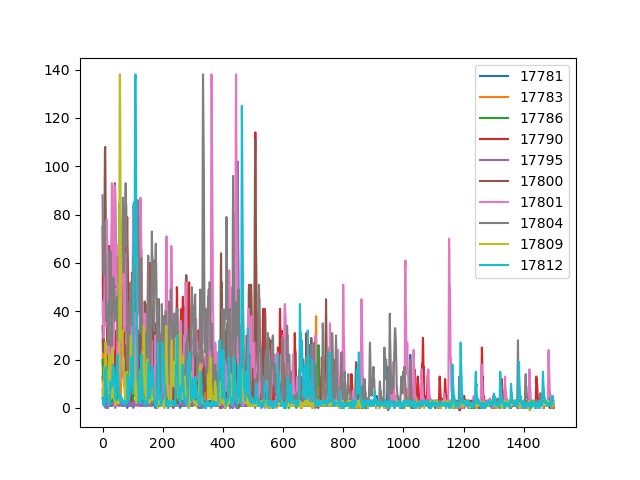

In [11]:
%matplotlib notebook
dfPulses.iloc[3000:3010,:].T.plot()
plt.show()

In [12]:
import random
randPulse = random.randrange(1000)
randPulse

355

<IPython.core.display.Javascript object>


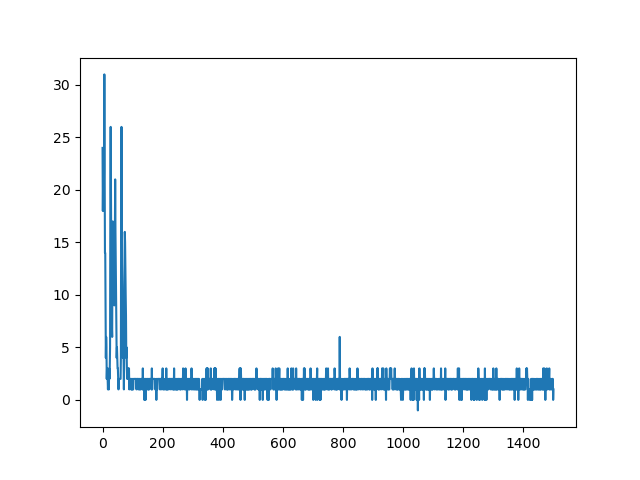

Valid: 1


In [13]:
%matplotlib notebook
sample = df2.iloc[randPulse,:]
sample.plot()
plt.show()
print("Valid: "+ str(validPulse(sample, 5, 10, 200, 1.25)))

# ===== DEBUGGING ENDS HERE :) =======

# Peaks sequence detection

In [ ]:
import random
randPulse = random.randrange(1000)
randPulse

In [ ]:
# Peak time distribution
samplePulse = dfPulses.iloc[randPulse]
samplePulse = samplePulse[:800]
samplePulse["peakLocations"] = pkdetect(samplePulse, 2, 5)
samplePulse

<IPython.core.display.Javascript object>


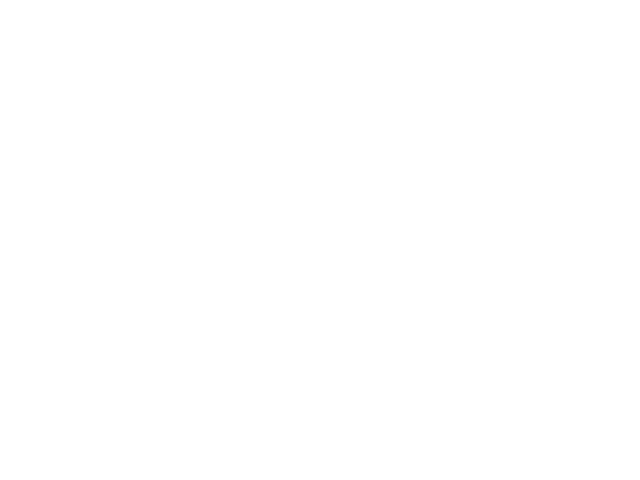

In [13]:
%matplotlib notebook
onlyPulse = samplePulse.iloc[:-1]
peaks = samplePulse.iloc[-1]
ax = onlyPulse.plot()
plt.plot(peaks, onlyPulse[peaks], 'r.')
plt.show()

In [ ]:
a = dfPulses.iloc[:100].copy()
a["peakLocations"] = a.apply(pkdetect, args = (5, 5), axis = 1)
b = a.loc[a["peakLocations"].map(len) > 1]
#b[b.columns[:15]]
c = b.loc[:,"peakLocations"]
c

In [11]:
#Add peak locations column to each pulse
dfPulses["peakLocations"] = dfPulses[dfPulses.columns[:PMT_PULSE_LENGTH]].apply(pkdetect, args = (2, 5), axis = 1)


#Remove pulses with less than 2 peaks
dfPulses = dfPulses.drop(dfPulses.loc[dfPulses["peakLocations"].map(len) < 2].T, axis = 0)
dfPulses

0   1   2    3   4   5   6   7   8   9  ...  1491  1492  1493  1494  \
1        6   6   4    4   2   3   3  17  27  20  ...     1     1     0     1   
6        8   4   4    2   1   3   2   1   3   2  ...     1     1     1     1   
10       8  11  13   10  13  25  37  37  30  29  ...     2     1     1     1   
35      36  31  33   26  21  40  61  60  47  41  ...     3     4     3     1   
39       4   4   5    3   1  11  10  12  17  19  ...     1     1     1     1   
...     ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
159028   3   3   4    2   1   3   5  17  24  30  ...     0     1     1     1   
159037   1   1   1  125  -2  19  35  36  29  36  ...     1     1     1     0   
159041   7   1   4    3   0   2   1   1   3   3  ...     0     1     0     1   
159048   3   4   2    2   1   3   1   9  15  12  ...     1     0     2     1   
159050   9   4   3    4   2   4  14  22  18  14  ...     1     1     1     2   

        1495  1496  1497  1498  1499  \
1          2     2     1     2     2   
6          1     2     1     1     2   
10         2     2     1     2     2   
35         3     4     2     3     2   
39         1     2     0     2     1   
...      ...   ...   ...   ...   ...   
159028     1     2     1     1     3   
159037     2     2     1     1     2   
159041     2     2     1     2     2   
159048     2     2     1     2     2   
159050     2     2     1     2     3   

                                            peakLocations  
1       [8, 16, 50, 69, 100, 111, 125, 138, 155, 183, ...  
6       [20, 44, 52, 142, 206, 220, 250, 262, 292, 356...  
10      [6, 11, 20, 30, 36, 46, 63, 70, 77, 86, 96, 11...  
35      [6, 13, 23, 32, 36, 39, 50, 56, 64, 73, 81, 88...  
39      [14, 22, 32, 56, 72, 78, 87, 98, 102, 125, 148...  
...                                                   ...  
159028  [10, 18, 40, 47, 64, 73, 89, 124, 137, 155, 16...  
159037  [3, 7, 14, 17, 23, 26, 30, 35, 51, 57, 61, 67,...  
159041  [19, 25, 32, 35, 45, 72, 79, 102, 109, 128, 15...  
159048              [8, 21, 100, 115, 220, 255, 292, 553]  
159050  [7, 20, 29, 43, 68, 75, 157, 184, 220, 226, 29...  

[29075 rows x 1501 columns]

### Time between first and Nth peaks

In [12]:
def relativeArrivalTimes(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[0]) #Relative time respect to first peak
    
    return deltaList

### Time between successive peaks

In [13]:
def timeBetweenPeaks(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[i]) #Relative time respect to first peak
    
    return deltaList

In [14]:
dfPulses["arrivalTimes"] = dfPulses["peakLocations"].apply(relativeArrivalTimes)
dfPulses

0   1   2    3   4   5   6   7   8   9  ...  1492  1493  1494  1495  \
1        6   6   4    4   2   3   3  17  27  20  ...     1     0     1     2   
6        8   4   4    2   1   3   2   1   3   2  ...     1     1     1     1   
10       8  11  13   10  13  25  37  37  30  29  ...     1     1     1     2   
35      36  31  33   26  21  40  61  60  47  41  ...     4     3     1     3   
39       4   4   5    3   1  11  10  12  17  19  ...     1     1     1     1   
...     ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
159028   3   3   4    2   1   3   5  17  24  30  ...     1     1     1     1   
159037   1   1   1  125  -2  19  35  36  29  36  ...     1     1     0     2   
159041   7   1   4    3   0   2   1   1   3   3  ...     1     0     1     2   
159048   3   4   2    2   1   3   1   9  15  12  ...     0     2     1     2   
159050   9   4   3    4   2   4  14  22  18  14  ...     1     1     2     2   

        1496  1497  1498  1499  \
1          2     1     2     2   
6          2     1     1     2   
10         2     1     2     2   
35         4     2     3     2   
39         2     0     2     1   
...      ...   ...   ...   ...   
159028     2     1     1     3   
159037     2     1     1     2   
159041     2     1     2     2   
159048     2     1     2     2   
159050     2     1     2     3   

                                            peakLocations  \
1       [8, 16, 50, 69, 100, 111, 125, 138, 155, 183, ...   
6       [20, 44, 52, 142, 206, 220, 250, 262, 292, 356...   
10      [6, 11, 20, 30, 36, 46, 63, 70, 77, 86, 96, 11...   
35      [6, 13, 23, 32, 36, 39, 50, 56, 64, 73, 81, 88...   
39      [14, 22, 32, 56, 72, 78, 87, 98, 102, 125, 148...   
...                                                   ...   
159028  [10, 18, 40, 47, 64, 73, 89, 124, 137, 155, 16...   
159037  [3, 7, 14, 17, 23, 26, 30, 35, 51, 57, 61, 67,...   
159041  [19, 25, 32, 35, 45, 72, 79, 102, 109, 128, 15...   
159048              [8, 21, 100, 115, 220, 255, 292, 553]   
159050  [7, 20, 29, 43, 68, 75, 157, 184, 220, 226, 29...   

                                             arrivalTimes  
1       [8, 42, 61, 92, 103, 117, 130, 147, 175, 191, ...  
6       [24, 32, 122, 186, 200, 230, 242, 272, 336, 34...  
10      [5, 14, 24, 30, 40, 57, 64, 71, 80, 90, 111, 1...  
35      [7, 17, 26, 30, 33, 44, 50, 58, 67, 75, 82, 91...  
39      [8, 18, 42, 58, 64, 73, 84, 88, 111, 134, 148,...  
...                                                   ...  
159028  [8, 30, 37, 54, 63, 79, 114, 127, 145, 157, 16...  
159037  [4, 11, 14, 20, 23, 27, 32, 48, 54, 58, 64, 72...  
159041  [6, 13, 16, 26, 53, 60, 83, 90, 109, 138, 147,...  
159048                  [13, 92, 107, 212, 247, 284, 545]  
159050  [13, 22, 36, 61, 68, 150, 177, 213, 219, 285, ...  

[29075 rows x 1502 columns]

In [15]:
dfPulses["timeBetweenPeaks"] = dfPulses["peakLocations"].apply(timeBetweenPeaks)
dfPulses

0   1   2    3   4   5   6   7   8   9  ...  1493  1494  1495  1496  \
1        6   6   4    4   2   3   3  17  27  20  ...     0     1     2     2   
6        8   4   4    2   1   3   2   1   3   2  ...     1     1     1     2   
10       8  11  13   10  13  25  37  37  30  29  ...     1     1     2     2   
35      36  31  33   26  21  40  61  60  47  41  ...     3     1     3     4   
39       4   4   5    3   1  11  10  12  17  19  ...     1     1     1     2   
...     ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
159028   3   3   4    2   1   3   5  17  24  30  ...     1     1     1     2   
159037   1   1   1  125  -2  19  35  36  29  36  ...     1     0     2     2   
159041   7   1   4    3   0   2   1   1   3   3  ...     0     1     2     2   
159048   3   4   2    2   1   3   1   9  15  12  ...     2     1     2     2   
159050   9   4   3    4   2   4  14  22  18  14  ...     1     2     2     2   

        1497  1498  1499                                      peakLocations  \
1          1     2     2  [8, 16, 50, 69, 100, 111, 125, 138, 155, 183, ...   
6          1     1     2  [20, 44, 52, 142, 206, 220, 250, 262, 292, 356...   
10         1     2     2  [6, 11, 20, 30, 36, 46, 63, 70, 77, 86, 96, 11...   
35         2     3     2  [6, 13, 23, 32, 36, 39, 50, 56, 64, 73, 81, 88...   
39         0     2     1  [14, 22, 32, 56, 72, 78, 87, 98, 102, 125, 148...   
...      ...   ...   ...                                                ...   
159028     1     1     3  [10, 18, 40, 47, 64, 73, 89, 124, 137, 155, 16...   
159037     1     1     2  [3, 7, 14, 17, 23, 26, 30, 35, 51, 57, 61, 67,...   
159041     1     2     2  [19, 25, 32, 35, 45, 72, 79, 102, 109, 128, 15...   
159048     1     2     2              [8, 21, 100, 115, 220, 255, 292, 553]   
159050     1     2     3  [7, 20, 29, 43, 68, 75, 157, 184, 220, 226, 29...   

                                             arrivalTimes  \
1       [8, 42, 61, 92, 103, 117, 130, 147, 175, 191, ...   
6       [24, 32, 122, 186, 200, 230, 242, 272, 336, 34...   
10      [5, 14, 24, 30, 40, 57, 64, 71, 80, 90, 111, 1...   
35      [7, 17, 26, 30, 33, 44, 50, 58, 67, 75, 82, 91...   
39      [8, 18, 42, 58, 64, 73, 84, 88, 111, 134, 148,...   
...                                                   ...   
159028  [8, 30, 37, 54, 63, 79, 114, 127, 145, 157, 16...   
159037  [4, 11, 14, 20, 23, 27, 32, 48, 54, 58, 64, 72...   
159041  [6, 13, 16, 26, 53, 60, 83, 90, 109, 138, 147,...   
159048                  [13, 92, 107, 212, 247, 284, 545]   
159050  [13, 22, 36, 61, 68, 150, 177, 213, 219, 285, ...   

                                         timeBetweenPeaks  
1       [8, 34, 19, 31, 11, 14, 13, 17, 28, 16, 9, 12,...  
6       [24, 8, 90, 64, 14, 30, 12, 30, 64, 8, 36, 41,...  
10      [5, 9, 10, 6, 10, 17, 7, 7, 9, 10, 21, 17, 23,...  
35      [7, 10, 9, 4, 3, 11, 6, 8, 9, 8, 7, 9, 8, 15, ...  
39      [8, 10, 24, 16, 6, 9, 11, 4, 23, 23, 14, 26, 3...  
...                                                   ...  
159028  [8, 22, 7, 17, 9, 16, 35, 13, 18, 12, 9, 7, 37...  
159037  [4, 7, 3, 6, 3, 4, 5, 16, 6, 4, 6, 8, 8, 9, 11...  
159041  [6, 7, 3, 10, 27, 7, 23, 7, 19, 29, 9, 42, 12,...  
159048                     [13, 79, 15, 105, 35, 37, 261]  
159050  [13, 9, 14, 25, 7, 82, 27, 36, 6, 66, 70, 6, 4...  

[29075 rows x 1503 columns]

## Relative time between first and Nth peak

<IPython.core.display.Javascript object>


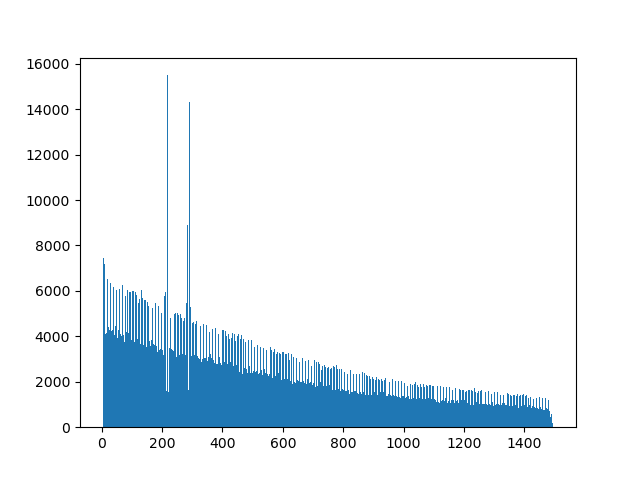

In [93]:
%matplotlib notebook
arrivalTimes = []
for i in dfPulses["arrivalTimes"]:
    arrivalTimes.extend(i)

nBinsFit = int(2*(len(arrivalTimes)**(2/5.0)))
# nBinsFit = 100

histData = plt.hist(arrivalTimes, bins = nBinsFit)
plt.show()

In [94]:
nBinsFit

601

# Model fitting
## Finding parameters of exponential distribution for relative times from first peak

In [95]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [96]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [97]:
fittingBoundsAmp = (1000, 100000)
fittingBoundsLam = (1e-6, 1.00)

In [98]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [99]:
distAmp

5683.908168619103

In [100]:
distLambda

0.0012197498248852105

<IPython.core.display.Javascript object>


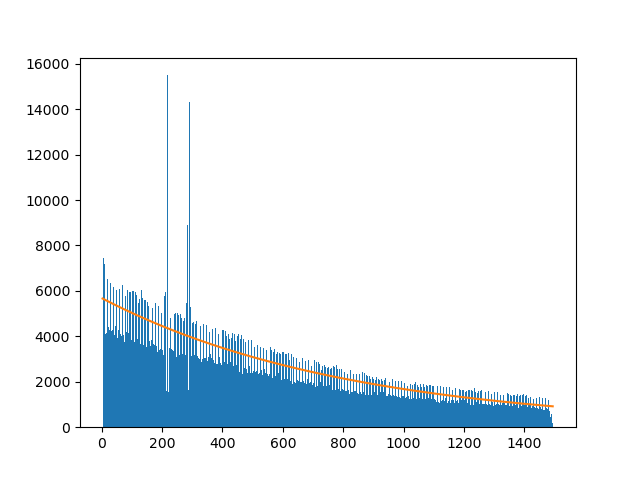

In [101]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(arrivalTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

In [102]:
len(arrivalTimes)

1569482

In [103]:
a = 0
for i in arrivalTimes:
    if (i < 219 and i > 216):
        a += 1

In [104]:
a

3815

## Finding parameters of exponential distribution for time between succesive peaks (Poisson)

<IPython.core.display.Javascript object>


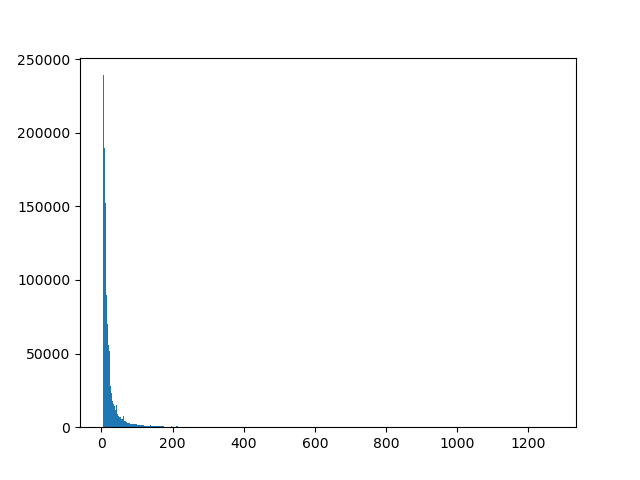

In [105]:
%matplotlib notebook
betweenPulsesTimes = []
for i in dfPulses["timeBetweenPeaks"]:
    betweenPulsesTimes.extend(i)

nBinsFit = int(2*(len(betweenPulsesTimes)**(2/5.0)))
    
histData = plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.show()

In [106]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [107]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [111]:
fittingBoundsAmp = (10000, 500000)
fittingBoundsLam = (1e-6, 1.00)

In [115]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [116]:
distAmp

328951.51295241097

In [117]:
distLambda

0.08992079516684158

<IPython.core.display.Javascript object>


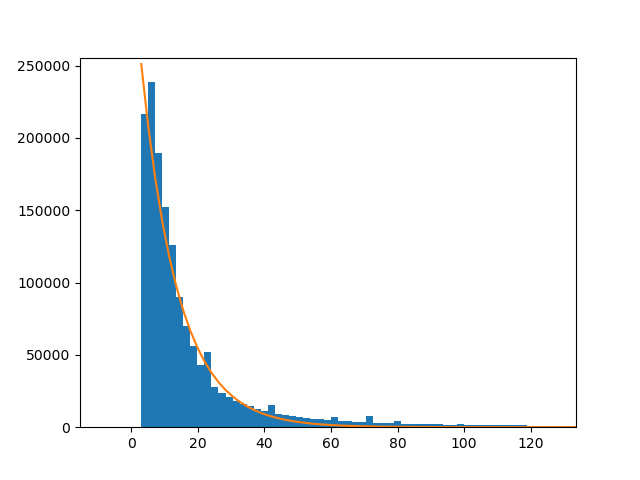

In [118]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()